### The German Traffic Sign Benchmark

Student Name 1: Alejandro Francisco Toral

Student Name 2: Enrique Martín López

In [1]:
# Download the data base
!wget -c http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2021-01-17 15:45:30--  http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
Resolving www.dia.fi.upm.es (www.dia.fi.upm.es)... 138.100.11.29
Connecting to www.dia.fi.upm.es (www.dia.fi.upm.es)|138.100.11.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  9.32MB/s    in 2m 52s  

2021-01-17 15:48:25 (9.20 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00008.ppm  
  inflating: FullIJCNN2013/00009.ppm  
  infla

In [2]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [3]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

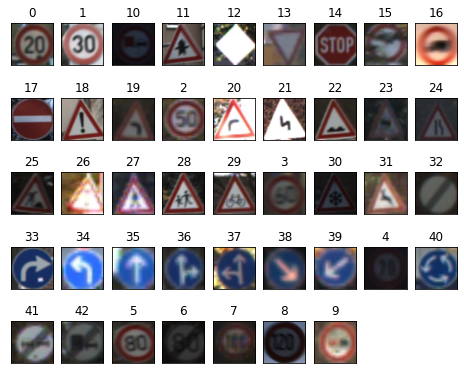

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [6]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

### Assignment 1: Multi-Layer Perceptron

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.initializers import he_normal
from keras.regularizers import l2
from keras import optimizers

In [9]:
from keras.initializers import he_uniform
learning_rate = 0.001
layers = [300,150,75]
layer_activation = "relu"
n_epochs = 150
batch_size = 64
my_initializer = he_uniform(seed=None)
d_rate = 0.01

In [10]:
mlp = Sequential()
mlp.add(Flatten(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
for layer in layers:
  mlp.add(Dense(layers[0], kernel_initializer=my_initializer, activation=layer_activation))
  mlp.add(Dropout(rate=d_rate))
mlp.add(Dense(num_classes))
mlp.add(Activation('softmax'))

opt = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 300)               45158700  
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0

In [11]:
data = mlp.fit(tr_signs, tr_labels, batch_size=batch_size, epochs=n_epochs, verbose=0, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

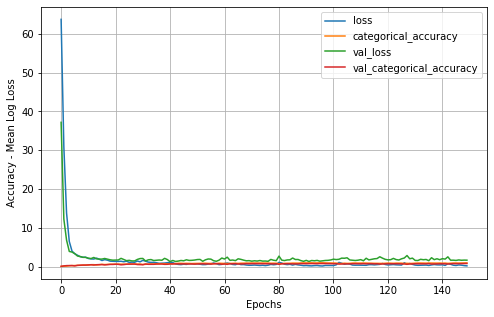

Accuracy  (training):  94.5 %
Accuracy (development test):  78.2 %


In [20]:
import pandas as pd

results = pd.DataFrame(data.history)
results.plot(figsize = (8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
#plt.gca().set_ylim(0, 1) # set the vertical range to [0,1]

plt.show()

print ("Accuracy  (training): ", 
       round((results.categorical_accuracy.values[-1:][0])*100, 1), "%")
print ("Accuracy (development test): ", 
       round((results.val_categorical_accuracy.values[-1:][0])*100, 1), "%")

In [13]:
start = time()
loss, acc = mlp.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('MLP took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

MLP took 0.14433574676513672 seconds
Test loss: 1.3529534339904785 - Accuracy: 0.811634361743927


Definición de una red convolucional multicapa

In [14]:
from keras.initializers import he_uniform
learning_rate = 0.001
layer_activation = "relu"

n_epochs = 150
batch_size = 64
my_initializer = he_uniform(seed=None)

d_rate = 0.1

In [15]:
# Convolutional Neural Network (CNN)
# Here you are allowed to use convolutional layers
# You may use also any regularizacion (see class slides)

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import keras.backend as K

model = Sequential()
model.add(Conv2D(filters=48, kernel_size=(3, 3), padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=d_rate))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=96, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=d_rate))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=192, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=d_rate))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(1, 1), padding='same', kernel_regularizer=l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=d_rate))
model.add(Conv2D(filters=num_classes, kernel_size=(4, 4), padding='valid'))
model.add(Flatten())

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 48)      1344      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 48)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 48)      192       
_________________________________________________________________
dropout_3 (Dropout)          (None, 224, 224, 48)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 48)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 96)      41568     
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 96)     

In [16]:
# Training
import time
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=batch_size, epochs=n_epochs, verbose=0, validation_data=(va_signs, va_labels))
end = time.time()
print("Training MLP took " + str(end - start) + " seconds")

Training MLP took 224.4521930217743 seconds


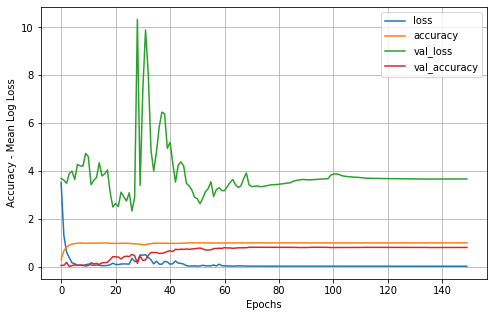

Accuracy  (training):  100.0 %
Accuracy (development test):  81.0 %


In [17]:
import pandas as pd

results = pd.DataFrame(history.history)
results.plot(figsize = (8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
#plt.gca().set_ylim(0, 1) # set the vertical range to [0,1]

plt.show()

print ("Accuracy  (training): ", 
       round((results.accuracy.values[-1:][0])*100, 1), "%")
print ("Accuracy (development test): ", 
       round((results.val_accuracy.values[-1:][0])*100, 1), "%")

In [18]:
loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 3.2846333980560303
Test accuracy: 0.8393352031707764
